Every Corpus has three main components: Conversations, Utterances, and Speakers.

See this link for more in depth tutorial: https://convokit.cornell.edu/documentation/tutorial.html

In [2]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import torch 
from torch.utils.data import Dataset
from transformers import BertTokenizer, AutoTokenizer
from tqdm import tqdm
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.classes.preprocessor import TextPreProcessor
from model1.spanemo.learner import Trainer, EvaluateOnTest
from model1.spanemo.model import SpanEmo
from model1.spanemo.data_loader import DataClass
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import datetime
import numpy as np
import json

c:\Users\tianq\Documents\Deep learning\deepEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
from convokit import Corpus, download
corpus = Corpus(filename=download("movie-corpus"))

In [2]:
corpus.print_summary_stats()

Number of Speakers: 9035
Number of Utterances: 304713
Number of Conversations: 83097


In [9]:
speakers_df = corpus.get_speakers_dataframe()

In [21]:
speakers_df.head()  

,vectors,meta.character_name,meta.movie_idx,meta.movie_name,meta.gender,meta.credit_pos
id,,,,,,
u0,[],BIANCA,m0,10 things i hate about you,f,4
u2,[],CAMERON,m0,10 things i hate about you,m,3
u3,[],CHASTITY,m0,10 things i hate about you,?,?
u4,[],JOEY,m0,10 things i hate about you,m,6
u5,[],KAT,m0,10 things i hate about you,f,2


In [3]:
convo_df = corpus.get_conversations_dataframe()

In [5]:
convo_df.head()

,vectors,meta.movie_idx,meta.movie_name,meta.release_year,meta.rating,meta.votes,meta.genre
id,,,,,,,
L1044,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L984,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L924,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L870,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L866,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"


In [6]:
utt_df = corpus.get_utterances_dataframe()

In [7]:
utt_df.head()

,timestamp,text,speaker,reply_to,conversation_id,meta.movie_id,meta.parsed,vectors
id,,,,,,,,
L1045,None,They do not!,u0,L1044,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[]
L1044,None,They do to!,u2,None,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[]
L985,None,I hope so.,u0,L984,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'I', 'tag': 'PRP',...",[]
L984,None,She okay?,u2,None,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'She', 'tag': 'PRP...",[]
L925,None,Let's go.,u0,L924,L924,m0,"[{'rt': 0, 'toks': [{'tok': 'Let', 'tag': 'VB'...",[]


In [10]:
utt_df.to_csv('utterances.csv', index=False)
speakers_df.to_csv('speakers.csv', index=False)
convo_df.to_csv('conversations.csv', index=False)

In [3]:
utt_df = pd.read_csv("C:\\Users\\tianq\\Documents\\Deep learning\\sci-res\\fun\\model2\\data\\cornell movie\\utterances.csv")

In [ ]:
utt_df

,timestamp,text,speaker,reply_to,conversation_id,meta.movie_id,meta.parsed,vectors
0,NaN,They do not!,u0,L1044,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[]
1,NaN,They do to!,u2,NaN,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[]
2,NaN,I hope so.,u0,L984,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'I', 'tag': 'PRP',...",[]
3,NaN,She okay?,u2,NaN,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'She', 'tag': 'PRP...",[]
4,NaN,Let's go.,u0,L924,L924,m0,"[{'rt': 0, 'toks': [{'tok': 'Let', 'tag': 'VB'...",[]
...,...,...,...,...,...,...,...,...
304708,NaN,Lord Chelmsford seems to want me to stay back ...,u9030,L666370,L666369,m616,"[{'rt': 2, 'toks': [{'tok': 'Lord', 'tag': 'NN...",[]
304709,NaN,I'm to take the Sikali with the main column to...,u9034,L666369,L666369,m616,"[{'rt': 1, 'toks': [{'tok': 'I', 'tag': 'PRP',...",[]
304710,NaN,"Your orders, Mr Vereker?",u9030,NaN,L666369,m616,"[{'rt': 1, 'toks': [{'tok': 'Your', 'tag': 'PR...",[]
304711,NaN,"Good ones, yes, Mr Vereker. Gentlemen who can ...",u9030,L666256,L666256,m616,"[{'rt': 1, 'toks': [{'tok': 'Good', 'tag': 'JJ...",[]


In [25]:
model_path = "C:\\Users\\tianq\\Documents\\Deep learning\\sci-res\\fun\\model1\\models\\4060Model.pt"

In [26]:
model = torch.load(model_path)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
seed = 12345678

if str(device) == 'cuda:0':
    print("Currently using GPU: {}".format(device))
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    print("WARNING: USING CPU")

In [7]:
pred_df = pd.DataFrame(columns=['utterance text', 'speaker', 'conversation_id', 'prediction'])
pred_df['utterance text'] = utt_df['text']
pred_df['speaker'] = utt_df['speaker']  
pred_df['conversation_id'] = utt_df['conversation_id']

In [8]:
pred_df = pred_df.dropna(subset=['utterance text'])

In [9]:
pred_df

,utterance text,speaker,conversation_id,prediction
0,They do not!,u0,L1044,NaN
1,They do to!,u2,L1044,NaN
2,I hope so.,u0,L984,NaN
3,She okay?,u2,L984,NaN
4,Let's go.,u0,L924,NaN
...,...,...,...,...
304708,Lord Chelmsford seems to want me to stay back ...,u9030,L666369,NaN
304709,I'm to take the Sikali with the main column to...,u9034,L666369,NaN
304710,"Your orders, Mr Vereker?",u9030,L666369,NaN
304711,"Good ones, yes, Mr Vereker. Gentlemen who can ...",u9030,L666256,NaN


In [10]:
utt_text = np.array(pred_df['utterance text'])

In [11]:


lengths = [len(s.split()) if type(s) == str else len(str(s).split()) for s in utt_text ]

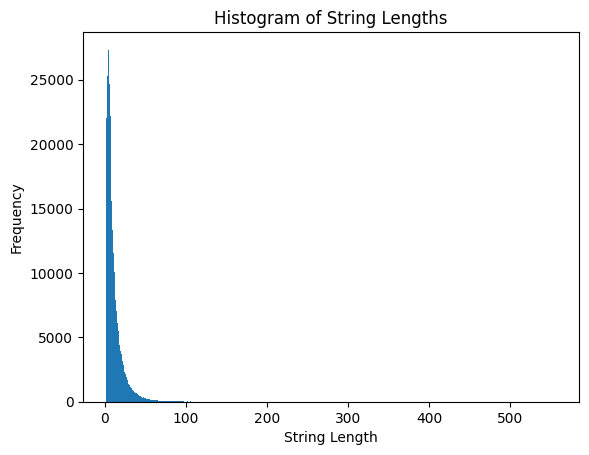

In [12]:
# Plot the histogram
plt.hist(lengths, bins=range(1, max(lengths) +2 ) )
plt.xlabel('String Length')
plt.ylabel('Frequency')
plt.title('Histogram of String Lengths')
plt.show()

In [13]:
hyperparams = {
    'train_path':utt_text, 
    'backbone':'bert-base-uncased',
    'max_length': 128, #maximum context length for the model
   
}

In [14]:
train_dataset = DataClass(hyperparams, utt_text, pred_mode=True)
train_data_loader = DataLoader(train_dataset,
                                    batch_size=128,
                                    shuffle=False)

c:\Users\tianq\Documents\Deep learning\deepEnv\lib\site-packages\ekphrasis\classes\tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...


c:\Users\tianq\Documents\Deep learning\deepEnv\lib\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter_2018 - 1grams ...


PreProcessing dataset ...:   0%|          | 0/304446 [00:00<?, ?it/s]c:\Users\tianq\Documents\Deep learning\deepEnv\lib\site-packages\transformers\tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
PreProcessing dataset ...: 100%|██████████| 304446/304446 [28:07<00:00, 180.36it/s]   


In [15]:
def test(model, model_path, loader=None):

    
    test_data_loader = loader

    
    learn = EvaluateOnTest(model, test_data_loader, model_path)
    learn.predict(device=device)

In [16]:
test(model, model_path, train_data_loader)

AttributeError: 'collections.OrderedDict' object has no attribute 'to'